In [1]:
#this is a data cleaning jupyter notebook on horse racing data

import pandas as pd
import numpy as np
import regex as re
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
import math
%pwd

'/home/neilfa/jupyter_data_cleaning'

In [2]:
with open('/proc/meminfo') as file:
    for line in file:
        if 'MemFree' in line:
            free_mem_in_kb = line.split()[1]
            break
file_path = '2019_1_1-2020_1_1.csv' 
file_size = os.path.getsize(file_path)
            
start = time.time()
df = pd.read_csv(file_path)
end = time.time()
index = df.index
num_row = len(index)

print('It takes {0} seconds to load in {1} rows of data (size of the file is {2} bytes), with {3} memory available'.format((end-start),num_row,file_size,free_mem_in_kb))

It takes 0.22748517990112305 seconds to load in 31651 rows of data (size of the file is 14016826 bytes), with 12729908 memory available


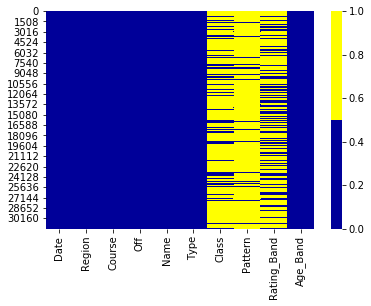

In [3]:
# missing values analysis

cols = df.columns[:10] # first 30
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

#normal for class to have missing values as Ireland races don't have a class




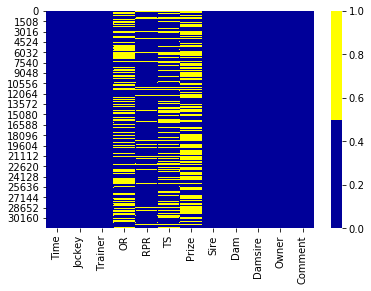

In [3]:

cols = df.columns[30:42] # last 12
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [4]:
df.columns

Index(['Date', 'Region', 'Course', 'Off', 'Name', 'Type', 'Class', 'Pattern',
       'Rating_Band', 'Age_Band', 'Sex_Rest', 'Dist', 'Dist_Y', 'Dist_M',
       'Dist_F', 'Going', 'Num', 'Pos', 'Ran', 'Draw', 'Btn', 'Ovr_Btn',
       'Horse', 'SP', 'Dec', 'Age', 'Sex', 'Wgt', 'Lbs', 'HG', 'Time',
       'Jockey', 'Trainer', 'OR', 'RPR', 'TS', 'Prize', 'Sire', 'Dam',
       'Damsire', 'Owner', 'Comment'],
      dtype='object')

In [67]:
# Gonna make a smaller dataframe (sm_df)
# Just to make it easier to work with

sm_df = df.loc[:,('Date','Off','Name','Horse','Pos','SP','Ran','Time','RPR','Prize','Class','Trainer','Jockey','Owner')]

sm_df.head()

,Date,Off,Name,Horse,Pos,SP,Ran,Time,RPR,Prize,Class,Trainer,Jockey,Owner
0,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Swordsman (IRE),1,3/1,15,5:1.80,127.0,€8008,NaN,Gordon Elliott,Jack Kennedy,Gigginstown House Stud
1,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Westport Lady (FR),2,8/1,15,5:4.20,111.0,€2483,NaN,W P Mullins,Paul Townend,Cathal Hughes
2,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Momus (IRE),3,10/11F,15,5:5.15,115.0,€1183,NaN,Noel Meade,Sean Flanagan,Gigginstown House Stud
3,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Tara Mill (IRE),4,25/1,15,5:5.40,112.0,€533,NaN,Shane Crawley,E OConnell,Shane Crawley
4,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Impatient Partner (IRE),5,8/1,15,5:5.70,111.0,€208,NaN,Noel Meade,Niall P Madden,John P Mcmanus


Colin Keane           764
Shane Foley           723
Chris Hayes           616
Sean Flanagan         582
Rachael Blackmore     557
                     ... 
Paula Muir              1
J OSullivan             1
Mr G Connolly           1
Paul OBrien             1
Mrs Pauline Condon      1
Name: Jockey, Length: 528, dtype: int64

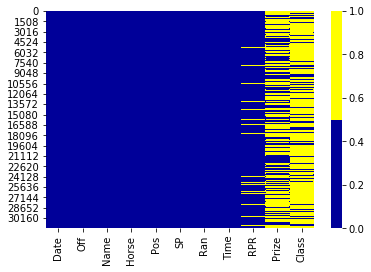

In [6]:
cols = sm_df.columns # last 12
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(sm_df[cols].isnull(), cmap=sns.color_palette(colours))

In [7]:
# sorting out the fractional odds to decimal odds, and having a new column saying if they are favourite
# decimal odds are easier to work with 
# decimal odds = numerator / denominator + 1

fodds = df.loc[:,'SP'] #fractional odds
fodds = fodds.str.replace("Evens","1/1")
fodds = fodds.str.replace("Evs","1/1")
splt = fodds.str.extract(r'(\d+).(\d+)(.?)')

splt.iloc[:,0] = splt.iloc[:,0].astype(float)
splt.iloc[:,1] = splt.iloc[:,1].astype(float)

dodds = (splt.iloc[:,0]/splt.iloc[:,1])+1 #decimal odds

odds_f = pd.concat([dodds,splt.iloc[:,2]],axis=1)

sm_df.loc[:,'SP'] = odds_f.iloc[:,0]
sm_df = pd.concat([sm_df,odds_f.iloc[:,1]],axis=1)


sm_df=sm_df.rename(columns={2:"Fav"})

#There are 3 possible letters that can come after the odds:
#F there is one favourite in the race (7/2F)
#J there are 2 favourite in the race (same odds) (7/2J,7/2J)
#C there are 3 favourite (3/1C,3/1C,3/1C)

#Instead of keeping the letters
#Gonna make a new column with series of bool - favorite TRUE or FALSE

sm_df.loc[:,"Fav"] = sm_df.loc[:,"Fav"].str.contains(r"\S") 

sm_df.head()





,Date,Off,Name,Horse,Pos,SP,Ran,Time,RPR,Prize,Class,Fav
0,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Swordsman (IRE),1,4.000000,15,5:1.80,127.0,€8008,NaN,False
1,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Westport Lady (FR),2,9.000000,15,5:4.20,111.0,€2483,NaN,False
2,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Momus (IRE),3,1.909091,15,5:5.15,115.0,€1183,NaN,True
3,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Tara Mill (IRE),4,26.000000,15,5:5.40,112.0,€533,NaN,False
4,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Impatient Partner (IRE),5,9.000000,15,5:5.70,111.0,€208,NaN,False


In [8]:
#New horse name with only the name
#New column with the horse's country

nme = sm_df.loc[:,'Horse']
splt = nme.str.extract(r"(.+)\s\((\w+)\)")
sm_df['Horse'] = splt.iloc[:,0]
sm_df['Horse_nation'] = splt.iloc[:,1]
sm_df.head(15)



,Date,Off,Name,Horse,Pos,SP,Ran,Time,RPR,Prize,Class,Fav,Horse_nation
0,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Swordsman,1,4.000000,15,5:1.80,127.0,€8008,NaN,False,IRE
1,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Westport Lady,2,9.000000,15,5:4.20,111.0,€2483,NaN,False,FR
2,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Momus,3,1.909091,15,5:5.15,115.0,€1183,NaN,True,IRE
3,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Tara Mill,4,26.000000,15,5:5.40,112.0,€533,NaN,False,IRE
4,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Impatient Partner,5,9.000000,15,5:5.70,111.0,€208,NaN,False,IRE
5,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,The Echo Boy,6,11.000000,15,5:11.30,85.0,NaN,NaN,False,IRE
6,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Galboystown Rose,7,101.000000,15,5:14.30,60.0,NaN,NaN,False,IRE
7,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Robbies Magic,8,101.000000,15,5:16.30,58.0,NaN,NaN,False,IRE
8,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Take A Turn,9,26.000000,15,5:17.10,51.0,NaN,NaN,False,IRE
9,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Goodkess,10,34.000000,15,5:24.50,17.0,NaN,NaN,False,IRE


In [9]:
#Now I need to convert time from string to actual time in seconds
#5:1.80 = 5min and 1.8 seconds
print(type(sm_df.loc[0,'Time']))
tme = sm_df['Time']
mtch = tme.str.extract(r"(\d+):(.+)")
mtch[0] = mtch[0].astype(float)
mtch[1] = mtch[1].astype(float)
sm_df['Time'] = (mtch[0]*60)+mtch[1]
#sm_df.iloc[[0,15],:]
sm_df.head()

<class 'str'>


,Date,Off,Name,Horse,Pos,SP,Ran,Time,RPR,Prize,Class,Fav,Horse_nation
0,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Swordsman,1,4.000000,15,301.80,127.0,€8008,NaN,False,IRE
1,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Westport Lady,2,9.000000,15,304.20,111.0,€2483,NaN,False,FR
2,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Momus,3,1.909091,15,305.15,115.0,€1183,NaN,True,IRE
3,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Tara Mill,4,26.000000,15,305.40,112.0,€533,NaN,False,IRE
4,2019-01-01,12:20,Happy New Year from all at Fairyhouse Maiden H...,Impatient Partner,5,9.000000,15,305.70,111.0,€208,NaN,False,IRE


In [10]:
#There is an important error to fix
#The name of a race might be duplicated ie, the same named race can occur on 2 different dates
#What needs to be done:
#1. Need to create a column identifying whether or not the race is a handicapped
    #creating a new bool series identicating whether the race is handicapped or not might be useful for analysis
#2. Create a new unique set of IDs for the race:
    # how to do this step I'm not sure

pattern = "andica"
sm_df['Handicap'] = sm_df['Name'].str.contains(pattern)


pattern2 = "aiden"
sm_df['Maiden_race'] = sm_df['Name'].str.contains(pattern2)
#total number of races = group by date, time of race(Off) and name
#ie. impossible for 2 race to occur at the same time on the same day with the same name


grpDN = sm_df.groupby(['Date','Off','Name']) 
grpN = sm_df.groupby(['Name'])

print("there are {} races with the same name\ntotal number of races is {} in 2019".format((grpDN.ngroups-grpN.ngroups),grpDN.ngroups))
print("there are {} races with the same name\ntotal number of races is {} in 2019".format((grpDN.ngroups-grpN.ngroups),grpDN.ngroups))

there are 406 races with the same name
total number of races is 2677 in 2019


In [28]:
#Creating a Unique ID for each race (UID)
#year(2019) + the index number (could be alphabetical) not important as long as the UID

UID = list()
racesnu = grpDN.ngroups
for i in range(racesnu):
    UID.append('2019'+(str(i+1)))

#append value to a already excisting key
#https://thispointer.com/python-how-to-add-append-key-value-pairs-in-dictionary-using-dict-update/#:~:text=this'%3A%2043%7D-,Append%20multiple%20key%20value%20pair%20in%20dictionary,it%20will%20update%20its%20value.
def append_value(dict_obj, key, value):
    # Check if key exist in dict or not
    if key in dict_obj:
        # Key exist in dict.
        # Check if type of value of key is list or not
        if not isinstance(dict_obj[key], list):
            # If type is not list then make it list
            dict_obj[key] = [dict_obj[key]]
        # Append the value in list
        dict_obj[key].append(value)
    else:
        # As key is not in dict,
        # so, add key-value pair
        dict_obj[key] = value    


#Still trying to find a way to easily assign UIDs
#Trying not to do any real complicated loops
#If you look at the pattern of 'Ran'
#it looks something like 3,3,3,4,4,4,4,2,2
#if I turn that list into 3,4,2 , Ie  first race 3 ran 2nd race 4 ran etc
#Then i can create a list that goes like:
    #repeat UID 3 times then repeat the next UID 4 times etc

lsRan = list(sm_df['Ran'])

for i, x in enumerate(lsRan):
    del lsRan[i+1:i+x]

#the loop below confirms that there is in fact 2677 not 2663
cnt =0 
test = dict(sm_df['Ran'].value_counts())
for keys in test:
    cnt += (test[keys]/keys)

lsUID = [] #list of all the UIDs that can go in the dataframe
for i in range(len(UID)):
    lc = [UID[i]]*lsRan[i]
    for j in lc:
        lsUID.append(j)
sm_df['UID']=lsUID

#Now each race a UID



In [26]:
races = sm_df.groupby(['UID']).mean()
races['Ran'].value_counts()
#sm_df.iloc[-1,:]

14    314
8     221
13    216
9     205
12    199
10    190
7     185
11    175
16    151
6     135
15    134
5     111
18    102
17    100
4      54
19     41
20     33
22     21
23     18
25     18
21     16
24     14
3      13
29      3
26      3
27      2
30      2
28      1
Name: Ran, dtype: int64

races = sm_df.groupby(['UID']).mean()


In [27]:
racegrp = sm_df.groupby(['Class'])
#rp = sm_df.groupby(['UID'])
racegrp.mean()
#sm_df['Prize']=sm_df['Prize'].str.extract(pat='€')
#sm_df['Prize']
#sm_df['Class'].isna().sum()

,SP,Ran,Time,RPR,Fav,Handicap,Maiden_race
Class,,,,,,,
Class 1,16.741273,10.927339,231.391717,110.304858,0.120734,0.285872,0.0
Class 2,14.800725,12.304348,366.332029,112.351852,0.115942,0.869565,0.0
Class 3,16.425373,15.439024,312.240976,106.063107,0.093496,1.000000,0.0
Class 4,16.834781,14.412099,305.755400,86.483840,0.084044,1.000000,0.0
Class 5,17.888621,15.142061,294.100348,76.615322,0.075905,1.000000,0.0
Class 6,12.055556,8.000000,369.651250,97.000000,0.125000,1.000000,0.0
Class 7,14.583333,12.055556,303.036944,93.060606,0.083333,1.000000,0.0


In [29]:
#Still trying to find a way to easily assign UIDs
#Trying not to do any real complicated loops
#If you look at the pattern of 'Ran'
#it looks something like 3,3,3,4,4,4,4,2,2
#if I turn that list into 3,4,2 , Ie  first race 3 ran 2nd race 4 ran etc
#Then i can create a list that goes like:
    #repeat UID 3 times then repeat the next UID 4 times etc

lsRan = list(sm_df['Ran'])

for i, x in enumerate(lsRan):
    del lsRan[i+1:i+x]

#the loop below confirms that there is in fact 2677 not 2663
cnt =0 
test = dict(sm_df['Ran'].value_counts())
for keys in test:
    cnt += (test[keys]/keys)

lsUID = []
for i in range(len(UID)):
    lc = [UID[i]]*lsRan[i]
    for j in lc:
        lsUID.append(j)


        


/usr/lib/python3/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


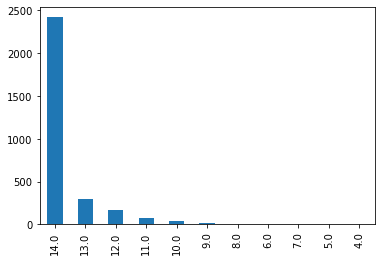

In [30]:
#Need to explore the RPR

#Hypothesis = Ones with no RPR will mostly always be towards the end
#Firstly need to sort out the position column

sm_df['true_Pos']=sm_df['Pos']
pos = sm_df.loc[:,('true_Pos')]
for i in range(len(pos)):
    try:
        int(pos[i])
    except:
        pos.iloc[i]=sm_df.loc[i,'Ran']

sm_df['true_Pos'] = pd.to_numeric(sm_df['true_Pos'])


RprBool = pd.isna(sm_df['RPR'])
TotalNan = sm_df[RprBool]


#Now need to evaluate if no RPR correlates to bottom position
#Because 5th position from 5 runners is the same as 12th from 12
#I need to normalise the positions, so that they all ressemble 10 horse race
#formula: (pos / ran) * 10 
normPos = list()
tot = sm_df.shape[0]
for i in range(tot):
    tP = sm_df.loc[i,'true_Pos']
    ran = sm_df.loc[i,'Ran']
    val = (tP/ran)*14
    normPos.append(val)
sm_df['normPos'] = normPos

sm_df['RprBool']=RprBool

RvP = sm_df.loc[:,('RprBool','normPos')]
RvP['normPos'] = RvP['normPos'].round()
RvPt = RvP[(RvP['RprBool']==True)]
RvPf = RvP[(RvP['RprBool']==False)]
vc = RvPt['normPos'].value_counts()
RvPhis = vc.plot(kind='bar')

#This graph shows you that indeed if the horse does not have an RPR
#It will most likely finish in a bottom position

















In [31]:
money = sm_df.loc[0,'Prize']
[float(re.findall(r'\d+',money)[0])]*7

[8008.0, 8008.0, 8008.0, 8008.0, 8008.0, 8008.0, 8008.0]

In [32]:
#Need to know to a basic correlation graph
#btwn: RPR and position
#RPR varies between races
#Need to know if IN GENERAL high RPR results in a better position outcome

#ln = sm_df.shape[0]


def difRPR(ser):
    ser = pd.to_numeric(ser)
    mx = ser.max()
    ln = len(ser)
    res = [mx]*ln
    return res-ser


races = sm_df.groupby('UID').groups

Races = sm_df.loc[:,'UID'].unique()

nas = np.empty((1,sm_df.shape[0]))
nas[:] = np.nan
sm_df['difRPR'] = nas[0]
sm_df['1stPrize']= nas[0]
RPRdic = {}
RPRdicH = {}
RPRdicNH = {}
#Class vs Price Analysis
cla_dic = {}

#races[Races[1]][1]


for i in Races:
    
    dfr = sm_df.loc[races[i],'RPR']
    ln = len(dfr)
    mn = dfr.min()    
    dfr = dfr.fillna(mn)
    dfr = pd.to_numeric(dfr)
    #RPRdic[i] = difRPR(dfr)
    sm_df.loc[races[i],'difRPR'] = difRPR(dfr)
    if sm_df.loc[races[i][0],'Ran'] == 14 and sm_df.loc[races[i][0],'Handicap'] == True:
        RPRdicH[i] = difRPR(dfr).values.tolist()
    elif sm_df.loc[races[i][0],'Ran'] == 14 and sm_df.loc[races[i][0],'Handicap'] == False:
        RPRdicNH[i] = difRPR(dfr).values.tolist()
        
    #Sorting out prize money in this loop
    index = races[i]
    ln = len(index)
    money = sm_df.loc[index[0],'Prize']
    fmon = float(re.findall(r'\d+',money)[0])
    sm_df.loc[index,'1stPrize']= [fmon]*ln
    
    
#dfr = sm_df.loc[races[Races[0]],'RPR']

#sm_df.loc[:,('difRPr','RPR')]
#sm_df.loc[races['20191'],'RPR'].min() 
       
#difRPR(sm_df.loc[races['201911'],'RPR'])

#sm_df.loc[:,'difRPR'].replace(races[Races[0]],difRPR(pd.to_numeric(sm_df.loc[races[Races[0]],'RPR'].fillna(17))),inplace=True)
#sm_df.loc[:,'difRPR']


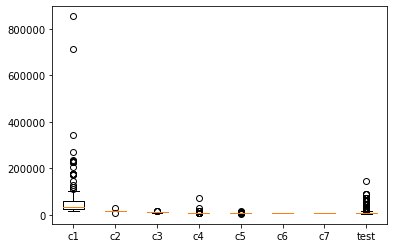

The winner's prize money in a class c1: Upper Q = 59000.0, Lower Q = 26845.0
The winner's prize money in a class c2: Upper Q = 18450.0, Lower Q = 15340.0
The winner's prize money in a class c3: Upper Q = 11820.0, Lower Q = 10401.0
The winner's prize money in a class c4: Upper Q = 7700.0, Lower Q = 6796.0
The winner's prize money in a class c5: Upper Q = 6468.0, Lower Q = 5910.0
The winner's prize money in a class c6: Upper Q = 7387.0, Lower Q = nan
The winner's prize money in a class c7: Upper Q = 7700.0, Lower Q = 6468.0
The winner's prize money in a class test: Upper Q = 10047.0, Lower Q = 6776.0


/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [33]:
#Class  vs Prize analysis
c1=[]
c2=[]
c3=[]
c4=[]
c5=[]
c6=[]
c7=[]
test=[]
clT = sm_df.loc[sm_df['Class'].notnull()]
#for i in Races:
 #   s
for i in Races:
    index = races[i]
    in1 = index[0]
    st1 = sm_df.loc[in1,'1stPrize']
    
    if sm_df.loc[in1,'Class'] == "Class 1":
        c1.append(st1)
    elif sm_df.loc[in1,'Class'] == "Class 2":
        c2.append(st1)
    elif sm_df.loc[in1,'Class'] == "Class 3":
        c3.append(st1)
    elif sm_df.loc[in1,'Class'] == "Class 4":
        c4.append(st1)
    elif sm_df.loc[in1,'Class'] == "Class 5":
        c5.append(st1)
    elif sm_df.loc[in1,'Class'] == "Class 6":
        c6.append(st1)
    elif sm_df.loc[in1,'Class'] == "Class 7":
        c7.append(st1)
    else:
        test.append(st1)

dict1 = {'c1':c1,'c2':c2,'c3':c3,'c4':c4,'c5':c5,'c6':c6,'c7':c7,'test':test}
        
#p_df = pd.DataFrame(d)
labels, data = [*zip(*dict1.items())]  # 'transpose' items to parallel key, value lists

# or backwards compatable    
labels, data = dict1.keys(), dict1.values()

plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
#plt.yticks(range(1,400000))
plt.show()

prizeQ = []

for i in dict1:
    values = sorted(dict1[i])
   # print(values)
    half = round(len(values)/2)
    #print(round(half))
    Q1 = np.median(values[:half])
    Q3 = np.median(values[half:])
    IQR = Q3-Q1
    prizeQ.append(Q3)
    prizeQ.append(Q1)
    print("The winner's prize money in a class {}: Upper Q = {}, Lower Q = {}".format(i,Q3,Q1))
prizeQ = [6500 if str(x)=='nan' else x for x in prizeQ]

In [34]:
prizeQ

[59000.0,
 26845.0,
 18450.0,
 15340.0,
 11820.0,
 10401.0,
 7700.0,
 6796.0,
 6468.0,
 5910.0,
 7387.0,
 6500,
 7700.0,
 6468.0,
 10047.0,
 6776.0]

In [35]:
p1 = int(round((prizeQ[1]+prizeQ[2])/2))
q2 = int(round((prizeQ[3]+prizeQ[4])/2))
p2 = range(q2,p1)
q3 = int(round((prizeQ[5]+prizeQ[6])/2))
p3 = range(q3,q2)
p4 = range(int(round((prizeQ[7]+prizeQ[8])/2)),q3)
#t = int((prizeQ[3]+prizeQ[4])/2)
#p2 = range(t,p1)
print(p1,p2,p3,p4)
sm_df.shape

22648 range(13580, 22648) range(9050, 13580) range(6632, 9050)


(31651, 21)

In [36]:
#Now I've gotten the quartile ranges need to assign classes to the nan classes which are lebelled as 'test'
#So if prize money is inbetween Q1 or Q3 of let's say class 1 then the class would be class 1 for that nan
#if the prize money lies in between lets say Q1 of class1 and Q3 of class2 then the formula would be:
#(Q1-prize)-(prize-Q3)=if neg then prize money is closer to Q1 of class 1 and thus should be assigned a class 1 for that nan



#for i in range(len(prizeQ)):
    #tbool = sm_df['Class']=='test'
    #pbool = sm_df['1stPrize'] 
    #if sm_df[]
st1 = sm_df.loc[:,('Class','1stPrize')]
p1 = int(round((prizeQ[1]+prizeQ[2])/2))#min for class 1
q2 = int(round((prizeQ[3]+prizeQ[4])/2))#range of prize money for class 2
p2 = range(q2,p1)
q3 = int(round((prizeQ[5]+prizeQ[6])/2))#range of prize money for class 3
p3 = range(q3,q2)
p4 = range(int(round((prizeQ[7]+prizeQ[8])/2)),q3) #range of prize money for class 4
pz = []
def p2c(x):
    if x>p1:
        return 'Class 1'
    elif x in p2:
        return 'Class 2'
    elif x in p3:
        return 'Class 3'
    elif x in p4:
        return 'Class 4'
    else:
        return 'Class 5'
    
#for i in range(st1.shape[0]):
 #   #print(st1.iloc[i,0])
  #  if str(st1.iloc[i,0]) != 'nan':# != 'test':
   #     pz.append(st1.iloc[i,0])
    #else:
     #   pz.append(p2c(st1.iloc[i,1]))
    

In [37]:
nas = np.empty((1,sm_df.shape[0]))
nas[:] = np.nan
st1['pz'] = nas[0]
st1[st1['Class'].empty and st1['1stPrize'] in p4] = 'Class 4'
st1.head(20)

,Class,1stPrize,pz,False
0,NaN,8008.0,NaN,Class 4
1,NaN,8008.0,NaN,Class 4
2,NaN,8008.0,NaN,Class 4
3,NaN,8008.0,NaN,Class 4
4,NaN,8008.0,NaN,Class 4
5,NaN,8008.0,NaN,Class 4
6,NaN,8008.0,NaN,Class 4
7,NaN,8008.0,NaN,Class 4
8,NaN,8008.0,NaN,Class 4
9,NaN,8008.0,NaN,Class 4


In [38]:
str(st1.iloc[0,0]) == 'nan'

True

AttributeError: module 'numpy.random' has no attribute 'randit'

In [40]:
#races_piv = sm_df.pivot(index = 'UID',columns = 'Horse',values=['1stPrize','Class'])
#races_piv.iloc[0,:].value_counts
#sm_df['Class']= sm_df['Class'].fillna('test')
#classes = sm_df.groupby('Class').min()
#sm_df['1stPrize']
#clas_df = pd.DataFrame.from_dict(RPRdicH,orient = 'index',columns = cols)
#pat = 'rade'
#grBool= sm_df['Name'].str.contains(pat)
#ext = sm_df['Name'].str.extract('Grade')
#t = sm_df.loc[grBool,'Name']
#cl_dic = {}


In [14]:
RPRdicNH

{'201910': [3.0,
  5.0,
  0.0,
  17.0,
  24.0,
  20.0,
  33.0,
  37.0,
  48.0,
  41.0,
  43.0,
  64.0,
  64.0,
  64.0],
 '201917': [0.0,
  2.0,
  3.0,
  12.0,
  21.0,
  27.0,
  24.0,
  28.0,
  33.0,
  32.0,
  37.0,
  44.0,
  50.0,
  74.0],
 '201925': [1.0,
  0.0,
  5.0,
  9.0,
  28.0,
  25.0,
  65.0,
  69.0,
  69.0,
  69.0,
  5.0,
  69.0,
  69.0,
  69.0],
 '201978': [0.0,
  9.0,
  17.0,
  28.0,
  29.0,
  44.0,
  48.0,
  51.0,
  71.0,
  74.0,
  82.0,
  107.0,
  107.0,
  107.0],
 '2019113': [0.0,
  5.0,
  6.0,
  7.0,
  10.0,
  11.0,
  13.0,
  13.0,
  14.0,
  15.0,
  17.0,
  17.0,
  19.0,
  19.0],
 '2019131': [0.0,
  7.0,
  13.0,
  20.0,
  18.0,
  22.0,
  24.0,
  27.0,
  27.0,
  37.0,
  81.0,
  92.0,
  92.0,
  92.0],
 '2019140': [5.0,
  7.0,
  0.0,
  17.0,
  18.0,
  11.0,
  24.0,
  28.0,
  22.0,
  23.0,
  37.0,
  38.0,
  32.0,
  65.0],
 '2019193': [0.0,
  13.0,
  27.0,
  23.0,
  22.0,
  23.0,
  44.0,
  42.0,
  53.0,
  50.0,
  50.0,
  72.0,
  84.0,
  31.0],
 '2019207': [4.0,
  0.0,
  4.0,


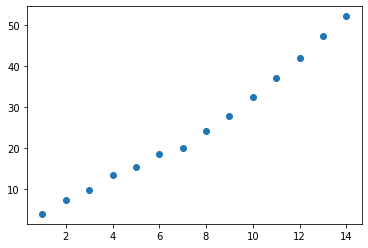

In [42]:
#sm_df.loc[:,('RPR','difRPR','Pos')].head(15)
cols =[]
for i in range(14):
    cols.append('Pos'+str(i+1))

    

rpH_df = pd.DataFrame.from_dict(RPRdicH,orient = 'index',columns = cols)
rpNH_df = pd.DataFrame.from_dict(RPRdicNH,orient = 'index',columns = cols)
means = []
for i in range(14):
    means.append(rpH_df.iloc[:,i].mean())
x = np.arange(1,15,1)

plt.scatter(x,means)
plt.show()



Text(0.5, 1.0, 'RPR difference for each positions for Non-Handicapped Races')

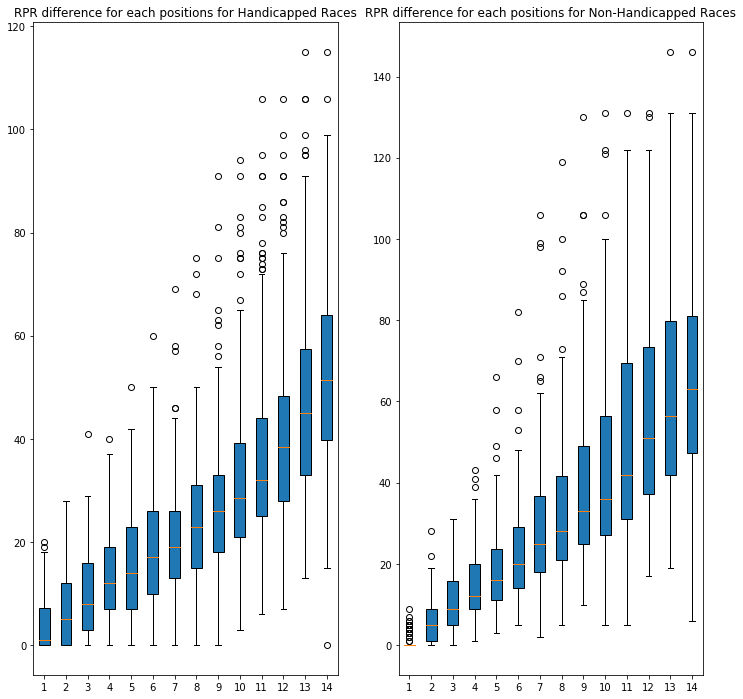

In [43]:


all_data = rpH_df.T
all_data2 = rpNH_df.T
labels = cols


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

# rectangular box plot
bplot1 = ax1.boxplot(all_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True)
bplot2 = ax2.boxplot(all_data2,
                     vert=True,  # vertical box alignment
                     patch_artist=True)# will be used to label x-ticks
ax1.set_title('RPR difference for each positions for Handicapped Races')
ax2.set_title('RPR difference for each positions for Non-Handicapped Races')

#https://www.olbg.com/blogs/profitable-horse-racing-betting-system-racing-post-ratings-improvers


In [45]:
#dictionary return function
RPRdicH[i] = difRPR(dfr).values.tolist()
# function returns a dictionary of the groupby method
#Could be useful for future analysis

lst = ['Horse', 'Pos']
#Function makes a dictionary according the variable(s) you want to look at
#inputs are df= dataframe
#lst = which variables you want to group by
#y = which variable you want to look at specifically (must be a list) ie, ['Pos','SP']
#if y == ['all'], it will take all variable results from df
def dicmake(df,lst,y):
    ln = len(lst)
    grp = sm_df.groupby(lst).groups
    if y[0] != 'all':
        grp1 = { x:df.ix[grp[x],y].values for x in grp}
    if y[0] == 'all':
        grp1 = { x:df.ix[grp[x],:].values.tolist()[0] for x in grp}
    return grp1
#dfH = dicmake(df,lst)


In [76]:
#Need to stop the analysis work
#Need more variables in more to create a better model
#Lets start with the winning % of horse
#7486 horses 

Hg = sm_df.groupby(['Horse']).groups 
Jg = sm_df.groupby(['Jockey']).groups 
Tg = sm_df.groupby(['Trainer']).groups
Og = sm_df.groupby(['Owner']).groups

grps = [Hg,Jg,Tg,Og]
colNames = ['H_avgW','H_avgP','J_avgW','J_avgP','T_avgW','T_avgP','O_avgW','O_avgP']
# Hg will be used often especially for horse analysis, keys = horse, values = index of the race horse ran in

#horses = Hg.mean().index.tolist()
#Creating an empty column where we will be iterating through the values
nas = np.empty((1,sm_df.shape[0]))
nas[:] = np.nan
sm_df['H_avgW'] = nas[0]
sm_df['H_avgP'] = nas[0]
sm_df['J_avgW'] = nas[0]
sm_df['J_avgP'] = nas[0]
sm_df['T_avgW'] = nas[0]
sm_df['T_avgP'] = nas[0]
sm_df['O_avgW'] = nas[0]
sm_df['O_avgP'] = nas[0]


Hap={}
NormP={}
dates={}
#creates dictionary of keys = horse name, value = Position in each race
pn = ['2','3']
win={}
place={}
dic = Hap
for j in range(len(grps)):
    g = grps[j]
    for key in g:
        index = g[key]
        value = sm_df.loc[Hg[key],'Pos'].tolist()
        #Hap[key] = sm_df.loc[Hg[key],'Pos'].tolist()
       # NormP[key] = sm_df.loc[Hg[key],'normPos'].tolist()
       # dates[key] = sm_df.loc[Hg[key],'Date'].tolist()


        #for key in dic:
         #   value = dic[key]
        cnt = 0
        b =[]
        d=[]
        cnt2=0
        for i in range(len(value)):
            if value[i] == '1':
                cnt += 1
                cnt2 += 1
                b.append(cnt/(i+1))
                d.append(cnt2/(i+1))
            elif value[i] in pn:
                cnt2 += 1
                d.append(cnt2/(i+1))
                b.append(cnt/(i+1))
            else:
                b.append(cnt/(i+1))
                d.append(cnt2/(i+1))
        colb = colNames[j*2]
        
        #print(len(grps),colNames[i*2])
        cold = colNames[(j*2)+1]
        sm_df.loc[index,colb] = b
        sm_df.loc[index,cold] = d
        
        #win[key]=b
        #place[key]=d


    
nas = np.empty((1,sm_df.shape[0]))
nas[:] = np.nan
sm_df['avgW'] = nas[0]
sm_df['avgP'] = nas[0]
place
#Hap['A New Dawn']


KeyError: 'A E Lynch'

0        1.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
31646    0.000000
31647    0.083333
31648    0.333333
31649    0.000000
31650    0.000000
Name: J_avgW, Length: 31651, dtype: float64

In [47]:
sm_df.columns

Index(['Date', 'Off', 'Name', 'Horse', 'Pos', 'SP', 'Ran', 'Time', 'RPR',
       'Prize', 'Class', 'Fav', 'Horse_nation', 'Handicap', 'Maiden_race',
       'UID', 'true_Pos', 'normPos', 'RprBool', 'difRPR', '1stPrize', 'avgW',
       'avgP'],
      dtype='object')

In [49]:


for key in Hg:
    index = Hg[key]
    valueW = win[key]
    valueP = place[key]
    #print(len(index),len(valueP))
    sm_df.loc[index,'avgW'] = valueW
    #print(type(sm_df.loc[index,['Horse','Pos']]))
    sm_df.loc[index,'avgP'] = valueP

#sm_df[('avgW','avgP')].head(15)



In [50]:
sm_df.loc[range(3000,3500),('Horse','avgW','avgP','Pos')]

,Horse,avgW,avgP,Pos
3000,So Enjoy,0.0,0.50,3
3001,Tashman,0.0,0.00,4
3002,Coral Blue,0.0,0.50,5
3003,Lignou,0.0,0.00,6
3004,Great Vizier,0.0,0.00,7
...,...,...,...,...
3495,Red Cymbal,0.0,0.00,6
3496,Eastern Racer,0.0,0.00,7
3497,Super Julius,0.0,0.00,8
3498,Annabelle Rock,1.0,1.00,1


In [51]:
#Want to do a expontential weighted average of normative position
#And a moving average too
#Could also do win% of last 4 runs


def ema(s, n):
    """
    returns an n period exponential moving average for
    the time series s

    s is a list ordered from oldest (index 0) to most
    recent (index -1)
    n is an integer

    returns a numeric array of the exponential
    moving average
    """
    s = np.array(s)
    ema = []
    j = 1

    #get n sma first and calculate the next n period ema
    sma = sum(s[:n]) / n
    multiplier = 2 / float(1 + n)
    ema.append(sma)

    #EMA(current) = ( (Price(current) - EMA(prev) ) x Multiplier) + EMA(prev)
    ema.append(( (s[n] - sma) * multiplier) + sma)

    #now calculate the rest of the values
    for i in s[n+1:]:
        tmp = ( (i - ema[j]) * multiplier) + ema[j]
        j = j + 1
        ema.append(tmp)
    return ema





In [52]:
len(Hg)

7486

In [53]:
nas = np.empty((1,sm_df.shape[0]))
nas[:] = np.nan
sm_df['emaNormP'] = nas[0]


emaNP = {}
for key in NormP:
    index =Hg[key]
    
    r = 3
    ln = len(NormP[key])
    zs = ln - r
    if ln > r:
        ems = [0]*(r-1)
        #print(NormP[key])
        Evalue = ema(NormP[key],r)
        for i in Evalue:
            ems.append(i)
        sm_df.loc[index,'emaNormP'] = ems
        emaNP[key] = ems
        #print(len(index),len(ems))
    else:
        emaNP[key] = [0]*ln
        sm_df.loc[index,'emaNormP'] = [0]*ln
        
        #print('x',len(index),len(ems))

sm_df.loc[range(10000,10015),['normPos','emaNormP','Horse']]
#emaNP

,normPos,emaNormP,Horse
10000,4.307692,0.000000,Nan Yehi
10001,5.384615,0.000000,Magic Fountain
10002,6.461538,0.000000,Arctic Blaze
10003,7.538462,0.000000,Annie Pender
10004,8.615385,0.000000,Nanafullam
10005,9.692308,0.000000,Light Of Fire
10006,10.769231,0.000000,Amareddy
10007,11.846154,0.000000,Celtic Red
10008,12.923077,13.079153,Muirisc
10009,14.000000,0.000000,Shabra's Rock


In [54]:
#Need to do days since last run for the horse
#(dates[3000]-dates[0]).days

nas = np.empty((1,sm_df.shape[0]))
nas[:] = np.nan
sm_df['days_since'] = nas[0]



day={}


    


def daysSince(dates):
    tdate = pd.to_datetime(dates)
    day0=[0] #Because there are no previous race for the first race.
    days=[(j-i).days for i, j in zip(tdate[:-1], tdate[1:])]
    #days = days.insert(0,0)
    days = day0+days
    #for i in range(len(tdate)):
        #print(type(tdate[i+1]))
        
     #   days.append((tdate[i+1]-tdate[i]).days)
    
    return days

for key in dates:
    index = Hg[key]
    values = daysSince(dates[key])
    sm_df.loc[index,'days_since'] = values
#test = dates['A Few Bob Short']
#test[1]-test[0]


In [55]:
#Rolling averages for Norm position is easier that one thinks
window = 3
Rolling=sm_df[['Horse','normPos']].groupby('Horse',as_index=True).rolling(window,min_periods=1).mean()

EWA=sm_df[['Horse','normPos']].groupby('Horse', as_index=True).apply(lambda g: g.normPos.ewm(window).mean())





In [63]:
# Horses 
#Rolling average and EWA for place%
window = 3
Horse_rolP=sm_df[['Horse','avgP']].groupby('Horse',as_index=True).rolling(window,min_periods=1).mean()
Horse_EwaP=sm_df[['Horse','avgP']].groupby('Horse', as_index=True).apply(lambda g: g.avgP.ewm(window).mean())

#Rolling Average and EWA for win%
Horse_rolW=sm_df[['Horse','avgW']].groupby('Horse',as_index=True).rolling(window,min_periods=1).mean()
Horse_EwaW=sm_df[['Horse','avgW']].groupby('Horse', as_index=True).apply(lambda g: g.avgW.ewm(window).mean())

#Rolling averages of the Normative Positioning
Horse_rolPos = sm_df[['Horse','normPos']].groupby('Horse',as_index=True).rolling(window,min_periods=1).mean()
Horse_EwaPos = sm_df[['Horse','normPos']].groupby('Horse', as_index=True).apply(lambda g: g.avgW.ewm(window).mean())

In [66]:
df.columns

Index(['Date', 'Region', 'Course', 'Off', 'Name', 'Type', 'Class', 'Pattern',
       'Rating_Band', 'Age_Band', 'Sex_Rest', 'Dist', 'Dist_Y', 'Dist_M',
       'Dist_F', 'Going', 'Num', 'Pos', 'Ran', 'Draw', 'Btn', 'Ovr_Btn',
       'Horse', 'SP', 'Dec', 'Age', 'Sex', 'Wgt', 'Lbs', 'HG', 'Time',
       'Jockey', 'Trainer', 'OR', 'RPR', 'TS', 'Prize', 'Sire', 'Dam',
       'Damsire', 'Owner', 'Comment'],
      dtype='object')